In [0]:
%pylab inline

from google.colab import files

from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm
from sklearn import model_selection

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from scipy.spatial import distance
from scipy.spatial.distance import cdist, pdist
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

import pandas as pd
import sys
import operator
import csv

Populating the interactive namespace from numpy and matplotlib


In [0]:
df = pd.read_csv('train.csv')
#X_test_df = pd.read_csv('test.csv')
X = df.loc[:, 'pixel0':]
Y = df['label']
#X_test_df

# 1B


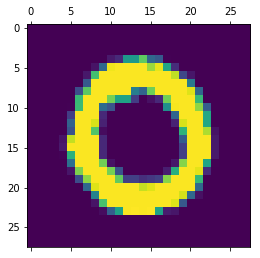

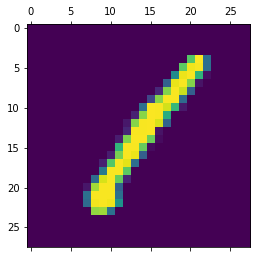

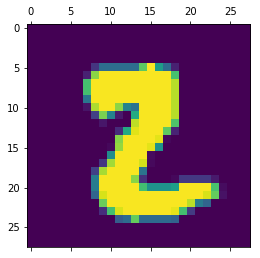

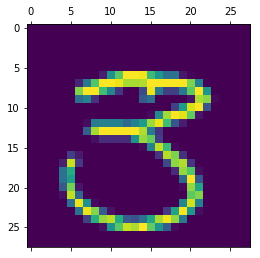

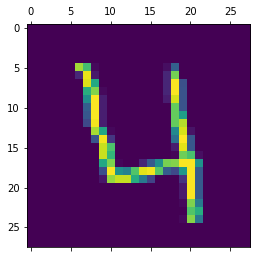

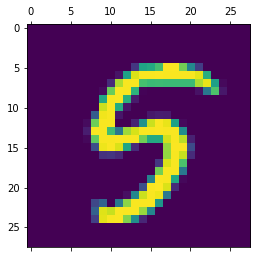

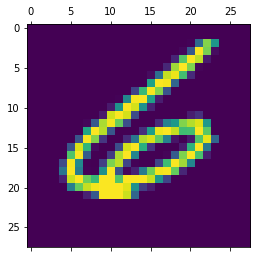

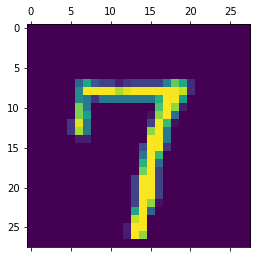

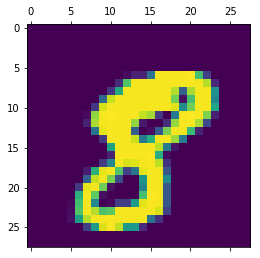

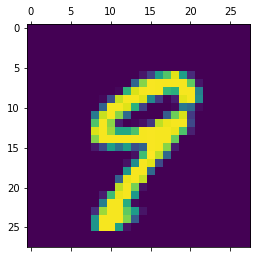

In [0]:


def get_digit_dataframe(digit):
  r = df[df['label'] == digit].iloc[[0]]
  return r, r.loc['pixel0':]

def get_digit(digit):
  r = df[df['label'] == digit].iloc[0]
  return r, r.loc['pixel0':]
  
def show_digit(digit):
  r = df[df['label'] == digit].iloc[0]
  digit_pixels = r.loc['pixel0':]
  matshow(digit_pixels.values.reshape(28,28))

for i in range(10):
  show_digit(i)
  
    

# 1C

Text(0.5, 0, 'Digit')

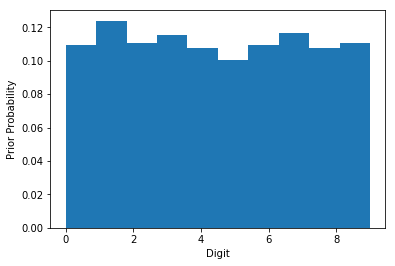

In [0]:
# Create a normalized histogram of digit label counts
plt.hist(Y, 10, density=True)
plt.ylabel("Prior Probability")
plt.xlabel("Digit")

# 1D

In [0]:
label_vals = df['label'].unique()
new_df = pd.DataFrame()
digit_dist_dict = {} #dictionary containing each digit as the key and a tuple of (label name, distance) as value

for elem in label_vals:
  row, pixels = get_digit(elem)
  row2 = get_digit_dataframe(elem)[0] #getting the row in datagrame format, in order to extract indices easier
  dist = sys.float_info.max
  for datapoint in df.itertuples(index=True): #iterating through all the training data
    new_dist = numpy.linalg.norm(datapoint[2:] - pixels) #since index = True above, the first element is the index number, the second element is the label, the third element is pixel0, etc. 
    if (datapoint[0] == row2.index.values): #ignore the case where it compares to itself
      continue
    
    if (new_dist < dist): #if there is a new smaller distance, update it in the dictionary
      digit_dist_dict[elem] = (datapoint[1], new_dist)
      dist = new_dist

digit_dist_dict

{0: (0, 1046.5954328201515),
 1: (1, 489.67948701165744),
 2: (2, 1380.877257398354),
 3: (5, 1832.6649993929605),
 4: (4, 1356.8809822530493),
 5: (5, 1066.3676664265472),
 6: (6, 1446.5113203843239),
 7: (7, 863.5010133172977),
 8: (8, 1593.7775879965184),
 9: (9, 910.5767403135224)}

# 1E
Consider the case of binary comparison between the digits 0 and 1. Ignoring all the other
digits, compute the pairwise distances for all genuine matches and all impostor matches,
again using the L2 norm. Plot histograms of the genuine and impostor distances on the same
set of axes.

[2217.55225418 2007.76891101 1917.77553431 ... 2607.41193523 2244.7964273
 1851.24336596]


Text(0.5, 0, 'Distance')

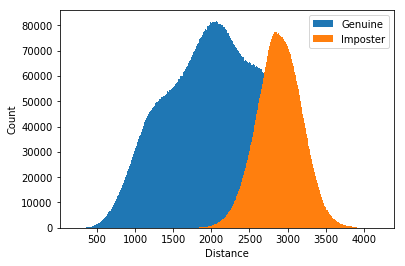

In [0]:
df_all_zeros = df[df.label == 0]
X_zeros = df_all_zeros.loc[:, 'pixel0':]

df_all_ones = df[df.label == 1]
X_ones = df_all_ones.loc[:, 'pixel0':]

# TODO: Use full dataset eventually
dist_genuine_zero = pdist(X_zeros, 'euclidean')
dist_imposter = cdist(X_zeros, X_ones, 'euclidean')
dist_genuine_one = pdist(X_ones, 'euclidean')

# Flatten matrix from cdist
imposter_plt_data = dist_imposter.flatten()
# Concatenate genuines into 1 distribution
gen_dists = numpy.concatenate((dist_genuine_one, dist_genuine_zero), axis=0)
print(gen_dists)

plt.hist(gen_dists, bins="auto")
plt.hist(imposter_plt_data, bins="auto")
plt.legend(["Genuine", "Imposter"])
plt.ylabel("Count")
plt.xlabel("Distance")

# 1F
Generate an ROC curve from the above sets of distances. What is the equal error rate? What
is the error rate of a classifier that simply guesses randomly?


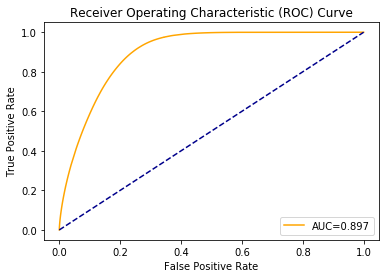

Equal Error Rate: 0.18557486137996923


In [0]:

# Helper to plot the ROC (https://stackabuse.com/understanding-roc-curves-with-python/)
def plot_roc_curve(fpr, tpr, auc):
  plt.plot(fpr, tpr, color='orange', label='ROC')
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(["AUC=%.3f" % auc])
  plt.show()

# concatenate genuine dists into one array
gen_dists = numpy.concatenate((dist_genuine_one, dist_genuine_zero), axis=0)
imposter_dists = imposter_plt_data
  
zeros = [0]*len(gen_dists)
ones = [1]*len(imposter_plt_data)
y_labels = np.concatenate((zeros, ones))

# Calculate fpr and tpr based on distances as confidence values
scores = np.concatenate((gen_dists, imposter_dists))
fpr, tpr, threshold = roc_curve(y_labels, scores)
auc = roc_auc_score(y_labels, scores)

# Plot the curve
plot_roc_curve(fpr, tpr, auc)

# Equal Error Rate: https://stackoverflow.com/questions/28339746/equal-error-rate-in-python
fnr = 1 - tpr
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("Equal Error Rate: {}".format(EER))

# 1G
Implement a K-NN classifier. (You cannot use external libraries for this question; it should be your own implementation.)

In [0]:
def euclidean_distance(vector1, vector2):
    return np.sqrt(np.sum(np.power(vector1-vector2, 2)))

In [0]:
def get_neighbors_optimized(X_train, X_test_instance, k):
    obj = X_train.apply(euclidean_distance, axis=1, args=[X_test_instance])
    obj.sort_values(ascending=True, inplace=True)
    return obj[0:k].index.values

In [0]:
#predictkNN Class implementation courtesy of the following link: https://anujkatiyal.com/blog/2017/10/01/ml-knn/#.XY0N85NKi1s

def predictkNNClass(output, y_train):
    classVotes = {}
    for i in output:
        if y_train.iloc[i] in classVotes:
            classVotes[y_train.iloc[i]] = classVotes[y_train.iloc[i]] + 1
        else:
            classVotes[y_train.iloc[i]] = 1
    
    sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]

In [0]:
neigh = get_neighbors(X.head(1000), X.iloc[1009], 3) #332, 840, 869
z = predictkNNClass(neigh, Y)
z

[(4, 3)]


4

# 1H
Using the training data for all digits, perform 3 fold cross-validation on your K-NN classifier and report your average accuracy.

In [0]:
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, Y, cv=3, scoring='accuracy')
print(scores)

[0.96458155 0.96328047 0.96478068]


# 1I
Generate a confusion matrix (of size 10×10) from your results. Which digits are particularly tricky to classify?

In [5]:
knn_classif = KNeighborsClassifier(n_neighbors=3)
knn_classif.fit(X, Y)
y_pred = knn_classif.predict(X)
#y_pred = knn_classifier.predict(X_test_df)

confusion_matrix(Y, y_pred)

array([[4122,    0,    1,    0,    0,    3,    6,    0,    0,    0],
       [   0, 4672,    4,    0,    1,    0,    0,    4,    1,    2],
       [  17,   20, 4107,    3,    1,    1,    1,   23,    2,    2],
       [   4,    5,   20, 4265,    0,   25,    0,   11,   11,   10],
       [   3,   29,    0,    0, 3997,    0,    5,    1,    0,   37],
       [   6,    2,    2,   29,    2, 3721,   23,    0,    1,    9],
       [  14,    5,    0,    0,    4,   10, 4104,    0,    0,    0],
       [   1,   35,   11,    0,    3,    0,    0, 4328,    0,   23],
       [  15,   28,    7,   31,   11,   23,    7,    5, 3913,   23],
       [   9,    6,    1,   19,   28,    5,    2,   27,    2, 4089]])

In [0]:
sy_true = Y.iloc[1001:2001] #Getting the true y labels for rows 1001 to 2000
y_true.values
y_pred = []

for index in range(1001, 2001):
  neigh = get_neighbors(X.head(1000), X.iloc[index], 3) #training on the first 1000 rows
  z = predictkNNClass(neigh, Y)
  y_pred.append(z) #appending the predictions

confusion_matrix(y_true, y_pred)

array([[ 86,   0,   0,   0,   0,   0,   3,   0,   0,   0],
       [  0, 120,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  10,  97,   1,   1,   0,   0,   3,   1,   0],
       [  0,   2,   4,  68,   0,   2,   0,   1,   5,   2],
       [  0,   1,   0,   0,  82,   0,   0,   0,   0,  18],
       [  2,   2,   0,   0,   0,  84,   3,   1,   3,   3],
       [  0,   0,   0,   0,   1,   0, 113,   0,   0,   0],
       [  1,   2,   0,   0,   2,   2,   0,  80,   0,   2],
       [  1,   3,   0,   9,   1,   1,   0,   1,  69,   6],
       [  0,   3,   0,   1,  12,   0,   0,   6,   0,  79]])

# 1J
Train your classifier with all of the training data, and test your classifier with the test data. Submit your results to Kaggle.

In [0]:
#Testing with sklearn's knn classifier
knn_classifier = KNeighborsClassifier(n_neighbors=9)
knn_classifier.fit(X, Y)
y_pred = knn_classifier.predict(X_test_df)
print(y_pred)

np.savetxt("y_pred.csv", y_pred, delimiter=",")

[2 0 9 ... 3 9 2]


In [0]:
#Our own implementation --- try to test if have time...

counter = 1
results_doc = open("results_doc.csv", "w")

subset = X_test_df.head(10)
for index in range(len(subset)):
    neigh = get_neighbors_optimized(X, subset.iloc[index], 3)
    predicted_label = predictkNNClass(neigh, Y)
    results_doc.write("(%d, %d)\n" %(index, predicted_label))